In [27]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

In [28]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

In [29]:
int2char_mm = {
    0 : '#',
    1 : '*',
    2 : '+',
    3 : '-',
    4 : 'B',
    5 : 'C',
    6 : 'D',
    7 : 'H',
    8 : 'L',
    9 : 'M',
    10 : 'P',
    11 : 'U',
    12 : 'W',
    13 : 'l',
    14 : 't',
    15 : 'w',
    16 : '|',
}

## Density

In [30]:
json_fname = './mma_gmvae_20_10000.json'
num_components = int(json_fname.split('_')[2])
num_gens_per_comp = 10000 // num_components

In [31]:
chunks_int = open_json_as_nparray(json_fname)
begin, end = 0, num_gens_per_comp
chunks_by_comp = []
for i in range(num_components):
    chunks_by_comp.append(chunks_int[begin:end])
    begin, end = begin + num_gens_per_comp, end + num_gens_per_comp

In [32]:
def get_densities(chunks):
    unique_indices = np.unique(chunks)
    densities = {i:[] for i in unique_indices}
    for idx, chunk in enumerate(chunks):
        for i in unique_indices:
            chunk_mod = chunk == i
            densities[i].append(np.count_nonzero(chunk_mod))
    return [np.mean(v) for k, v in densities.items()]

In [33]:
densities_by_comp = [get_densities(chunks) for chunks in chunks_by_comp]
len(densities_by_comp)

20

In [34]:
df = pd.DataFrame(densities_by_comp)
df = df.fillna(0)
df /= df.max()
df.columns = [int2char_mm[i] for i in np.unique(chunks_int)]
df = df.iloc[:,:-1]
df.head()

,#,*,+,-,B,C,D,H,L,M,P,U,W,l,t,w
0,0.616100,0.000010,0.000117,0.522369,0.020852,0.179584,0.000794,0.052750,0.002950,0.020718,0.717870,0.065217,0.504065,1.000000,0.111431,0.600223
1,1.000000,0.246004,0.093540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.305966,0.920214,0.002701,0.000009,0.009864,0.017958,0.026984,0.857964,0.001017,0.000092,0.003245,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.538759,0.000051,0.000094,0.559656,0.073667,0.171078,0.011111,0.029249,0.000610,0.001110,0.830880,0.478261,0.040650,0.011976,0.150817,0.043430
4,0.072777,0.000010,0.000012,1.000000,0.001623,0.123819,0.001587,0.148707,0.879947,0.003422,0.002374,0.717391,0.560976,0.000000,0.000000,0.000000


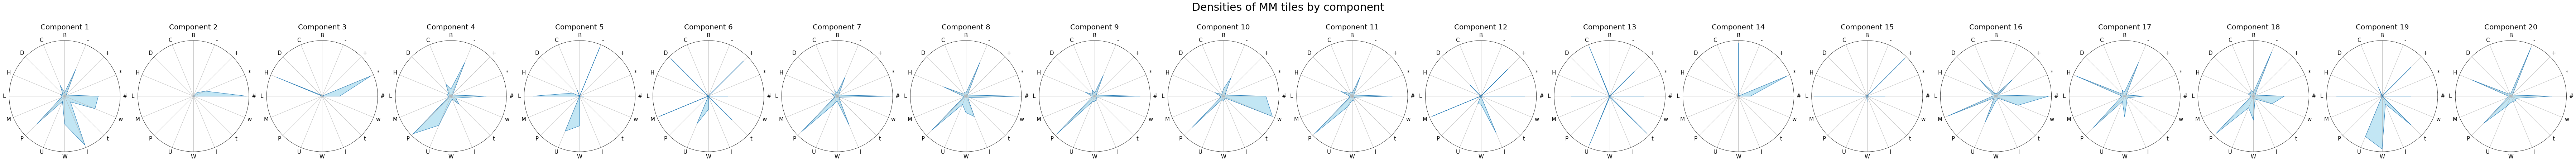

In [35]:
categories = list(df)

fig, axs = plt.subplots(nrows=1, ncols=num_components, figsize=(num_components * 5, 5),
                           subplot_kw=dict(polar=True))
axs = axs.flatten()

for i in range(num_components):
    
    ax = axs[i]
    
    values = df.iloc[i].tolist()
    values += values[:1] # repeat the first value to close the circular graph
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=15)
    ax.set_yticks([])
    ax.set_rlabel_position(30)

    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'skyblue', alpha=0.5)
    
    ax.set_title(f'Component {i+1}', y=1.08, fontsize=20)

plt.suptitle('Densities of MM tiles by component', y=1.20, fontsize=30)
plt.tight_layout()
plt.show()

## Plotting generations from each component

In [36]:
import sys
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

In [37]:
def get_images(chunks_int):
    images = []
    for chunk in chunks_int:
        images.append(vglc_with_path_encodings.array_to_image([chunk], game='mma')[0])
    return images

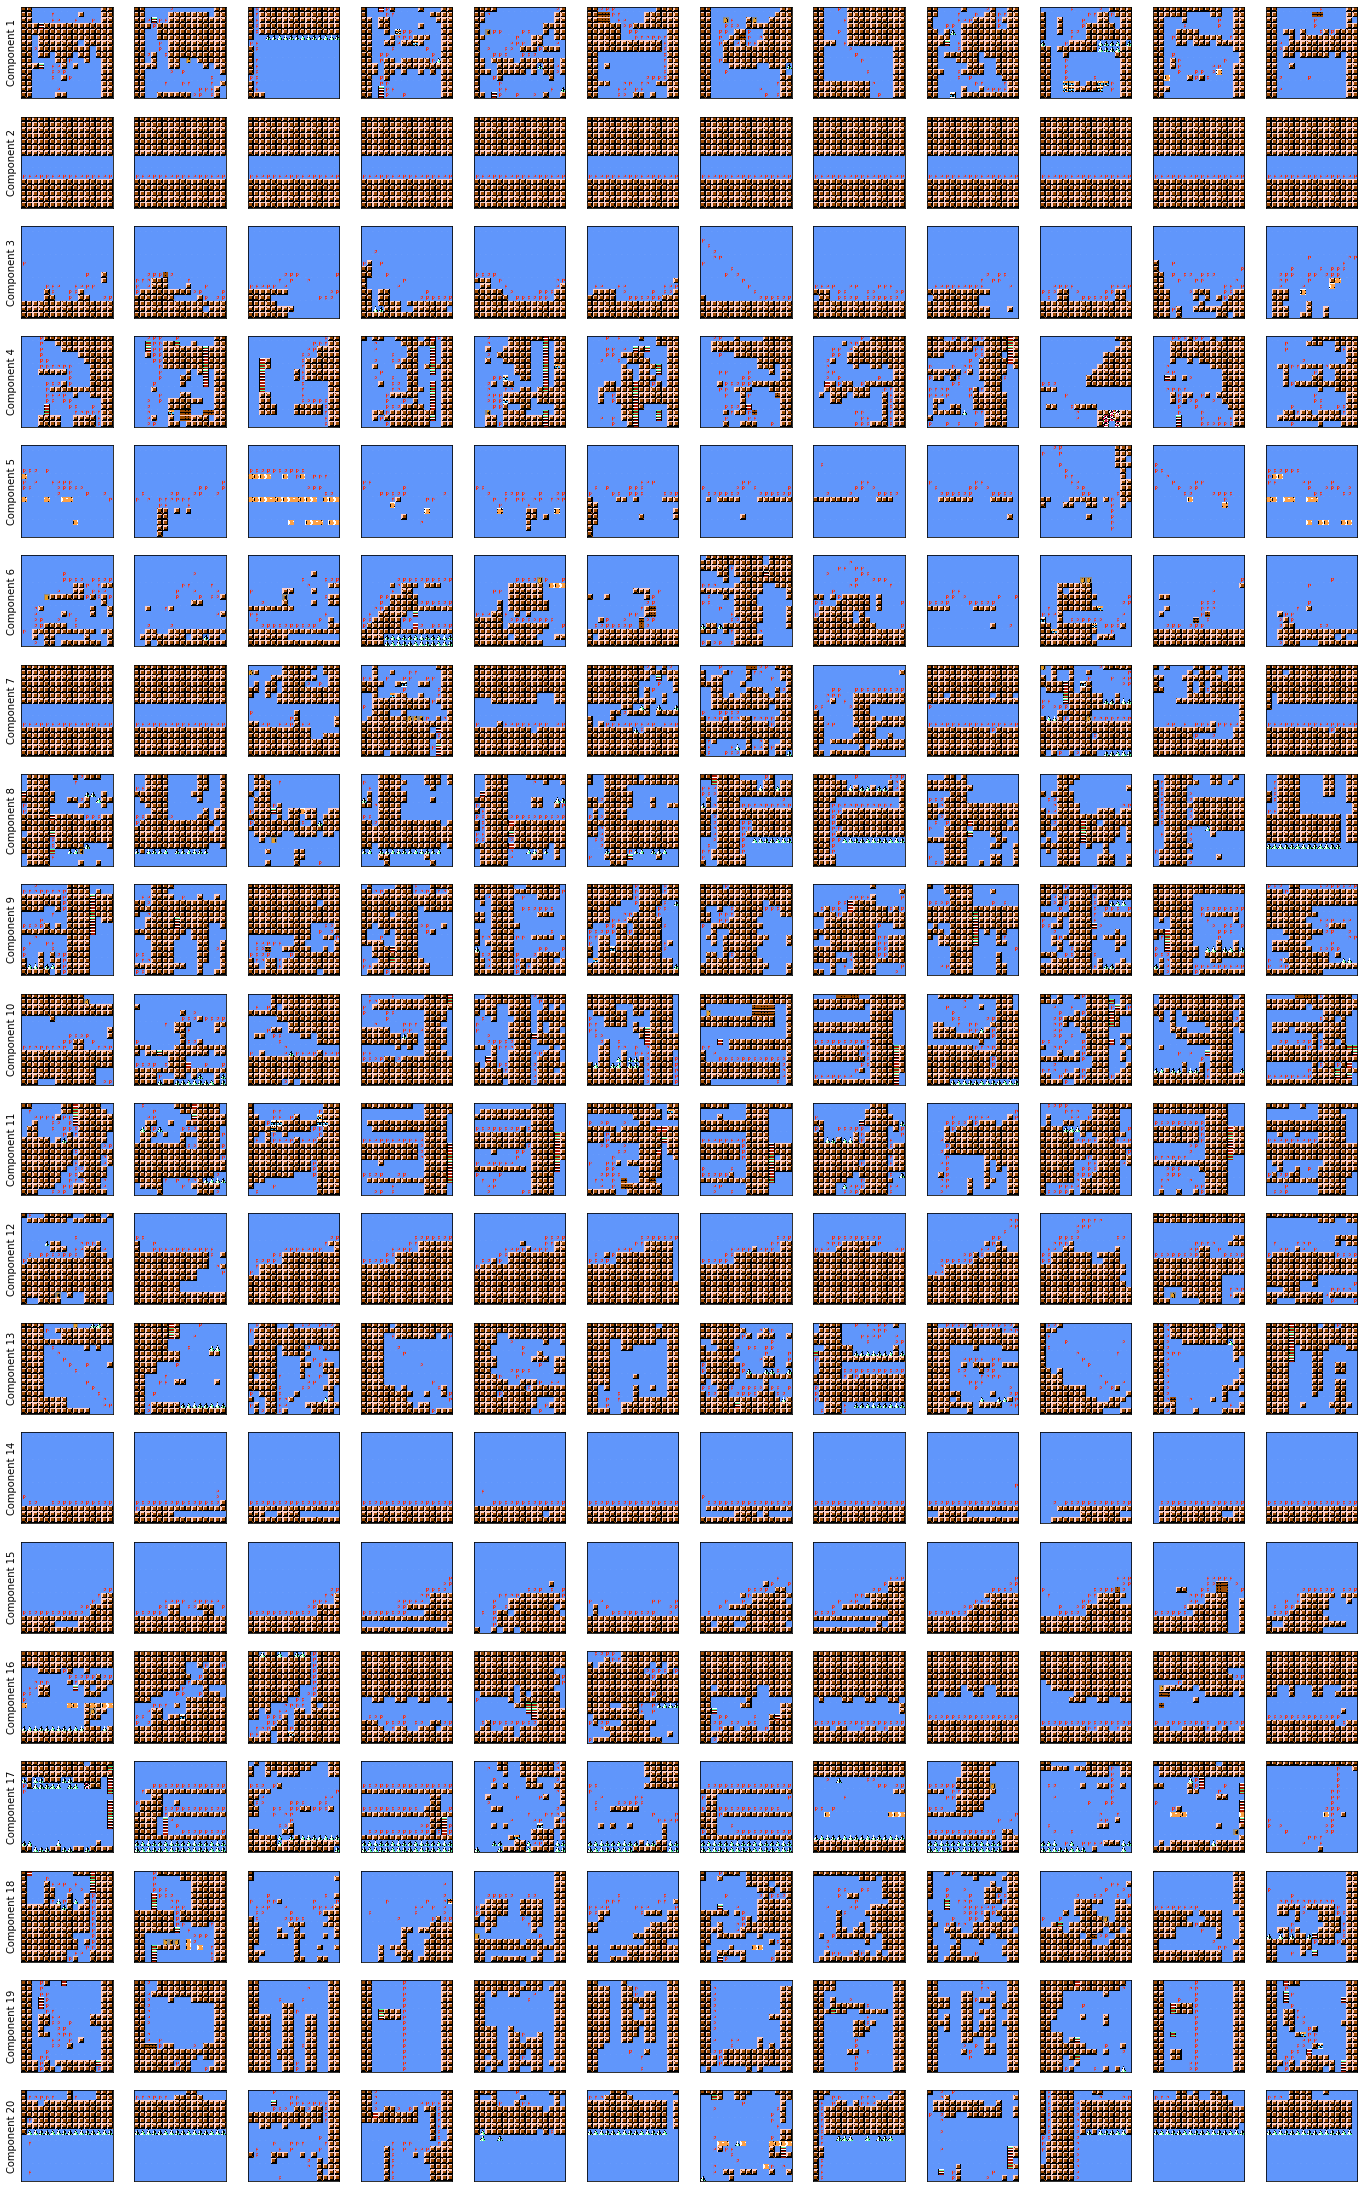

In [38]:
num_cols = 12
fig, axs = plt.subplots(num_components, num_cols, figsize=(2 * num_cols, 2 * num_components))
for comp_idx, chunks in enumerate(chunks_by_comp):
    imgs = get_images(chunks[:num_cols])
    for img_idx, img in enumerate(imgs):
        if img_idx == 1:
            ax.set_ylabel(f'Component {comp_idx + 1}')
        ax = axs[comp_idx][img_idx]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
plt.savefig(f'MMA generations per component (GM-VAE {num_components}).png', dpi=250)